### Loading libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import cv2

### Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_dir = r"/content/drive/MyDrive/TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

Mounted at /content/drive


### Understanding the Dataset

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [6]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


### Visualization

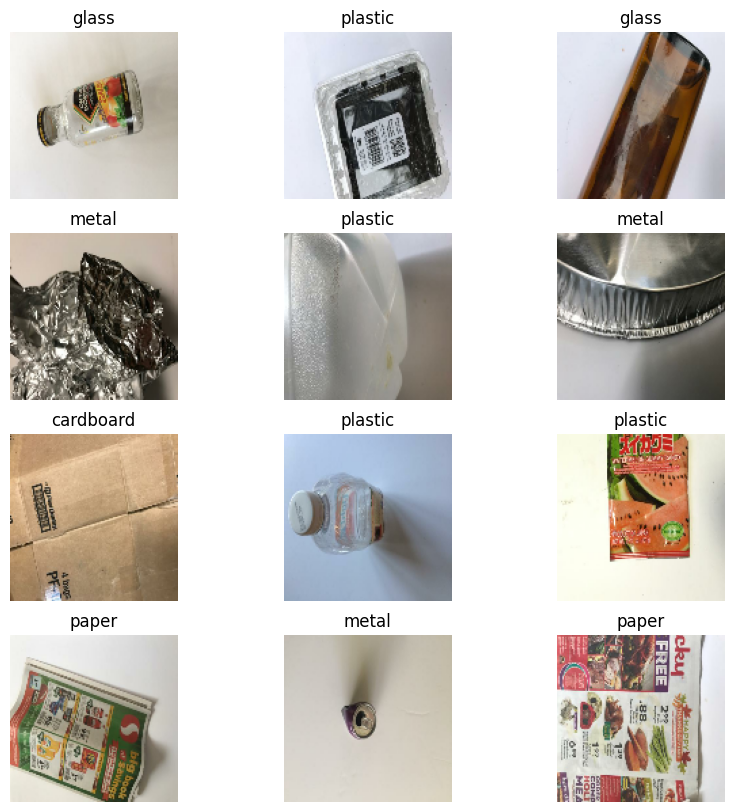

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [9]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [10]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


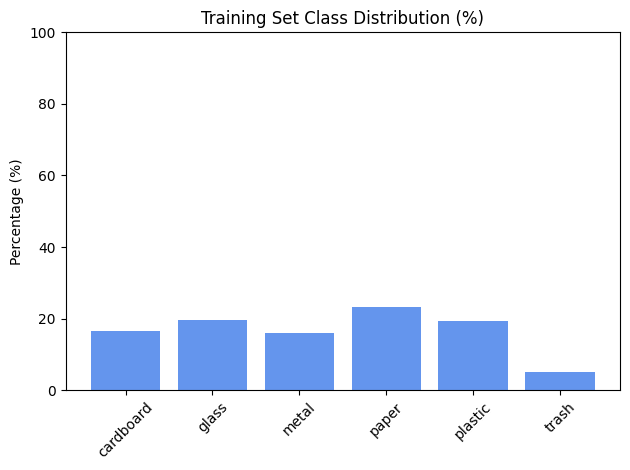

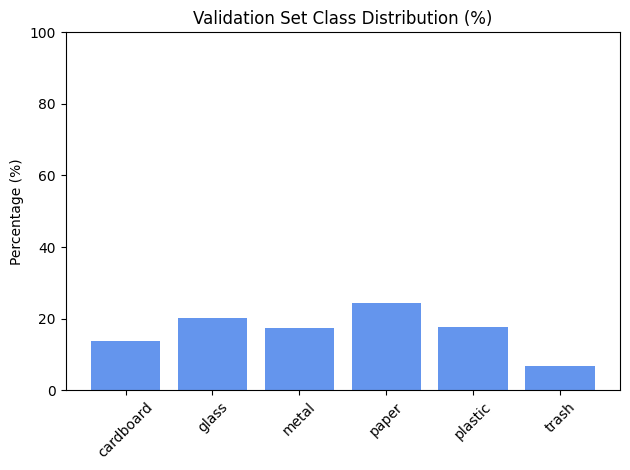

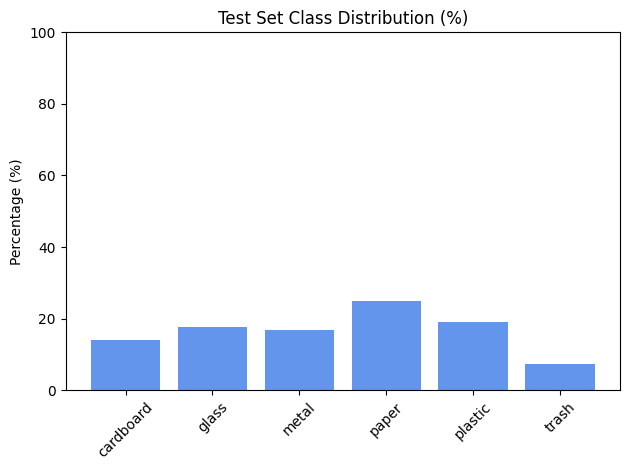

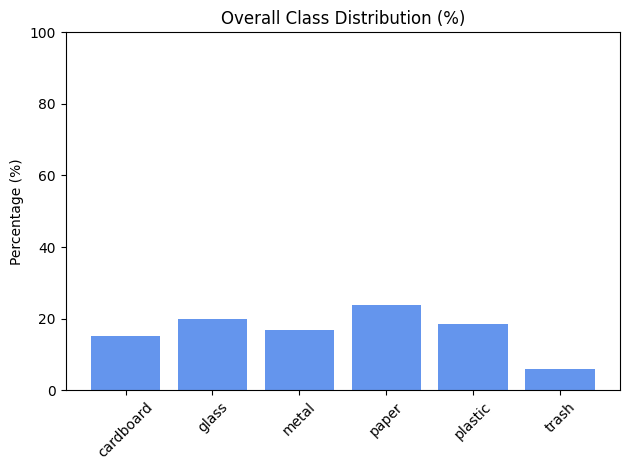

In [11]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [12]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [13]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


### Data Preprocessing

In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

### Model

In [15]:
# Load ResNet50 as base model
base_model = ResNet50(
    include_top=False,
    input_shape=(124, 124, 3),
    weights='imagenet'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [17]:
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [18]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
#Callback - to stop training when validation score stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [20]:
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - accuracy: 0.4392 - loss: 1.5333 - val_accuracy: 0.7426 - val_loss: 0.9199
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.8423 - loss: 0.5079 - val_accuracy: 0.8178 - val_loss: 0.6229
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.8974 - loss: 0.2919 - val_accuracy: 0.8495 - val_loss: 0.5154
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 312s 4s/step - accuracy: 0.8998 - loss: 0.2665 - val_accuracy: 0.8455 - val_loss: 0.5002
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.9380 - loss: 0.1595 - val_accuracy: 0.8475 - val_loss: 0.5524
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.9679 - loss: 0.0953 - val_accuracy: 0.8515 - val_loss: 0.4582
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - accuracy: 0.9608 - loss: 0.1188 - val_accuracy: 0.8733 - val_loss: 0.3943
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.9746 - loss: 0.0879 - val_accuracy: 0.8634 - v

In [21]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 130, 130,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 62, 62,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 62, 62,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 62, 62,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 64, 64,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 31, 31,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 31, 31,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 31, 31,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 31, 31,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 31, 31,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 31, 31,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 31, 31,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 31, 31,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 31, 31,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 31, 31,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 31, 31,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 19,452,928 (74.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

### Model Performance

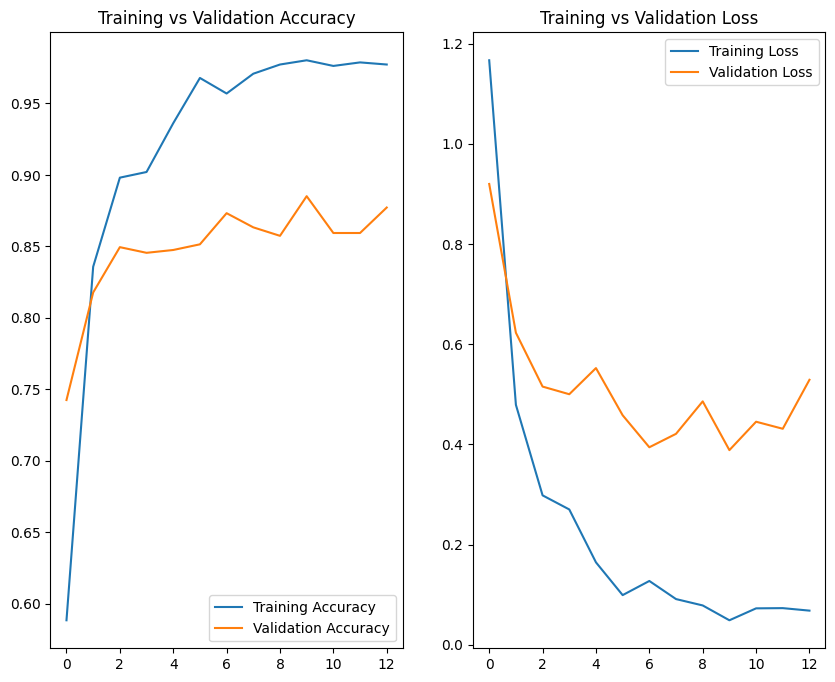

In [22]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

### Evaluation

In [23]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8697 - loss: 0.5186
Test accuracy is0.8750, Test loss is 0.4368


In [24]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them
y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [25]:
cm = confusion_matrix(y_true, y_pred)

In [26]:
print(cm)
print(classification_report(y_true, y_pred))

[[29  0  3  0  0  0]
 [ 0 40  4  0  2  0]
 [ 0  2 42  0  0  1]
 [ 4  0  2 49  1  1]
 [ 1  4  1  0 48  1]
 [ 0  0  1  3  1 16]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.87      0.87      0.87        46
           2       0.79      0.93      0.86        45
           3       0.94      0.86      0.90        57
           4       0.92      0.87      0.90        55
           5       0.84      0.76      0.80        21

    accuracy                           0.88       256
   macro avg       0.87      0.87      0.87       256
weighted avg       0.88      0.88      0.88       256



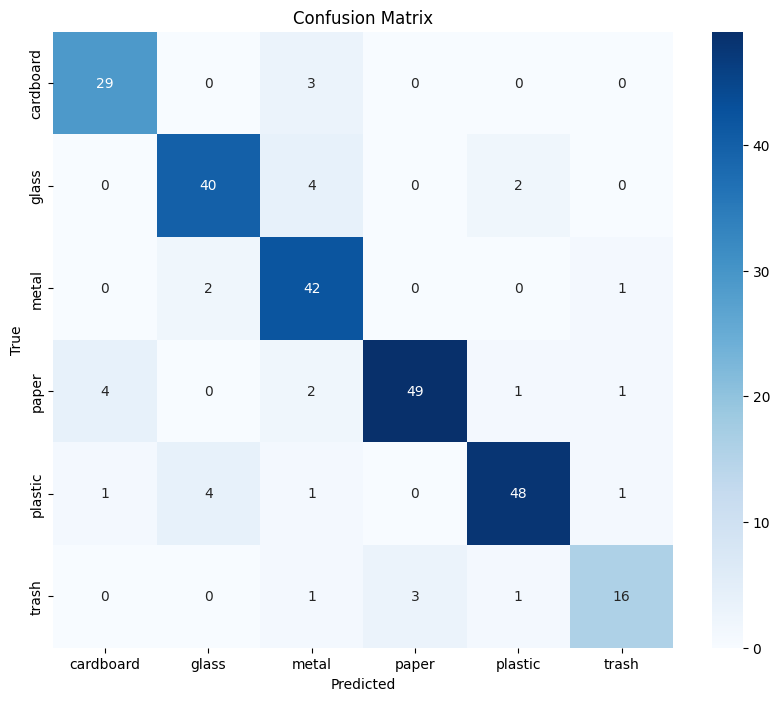

In [27]:
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


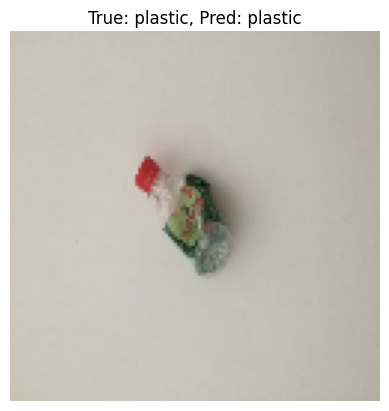

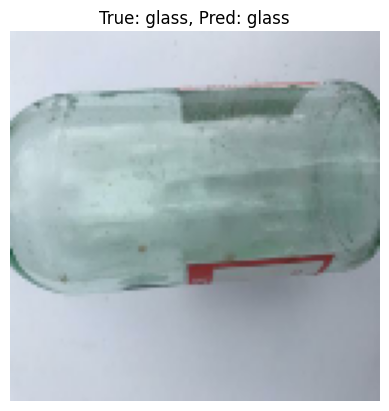

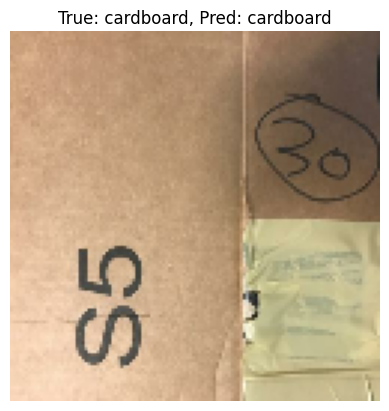

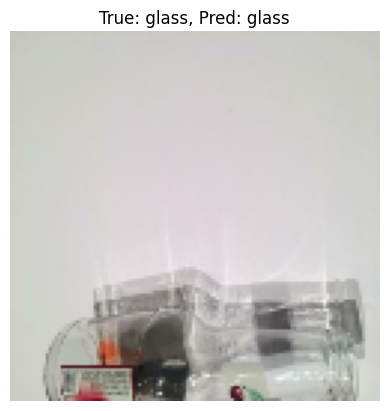

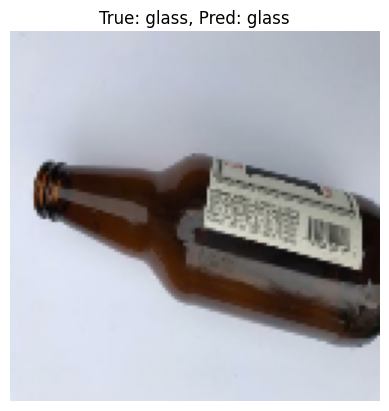

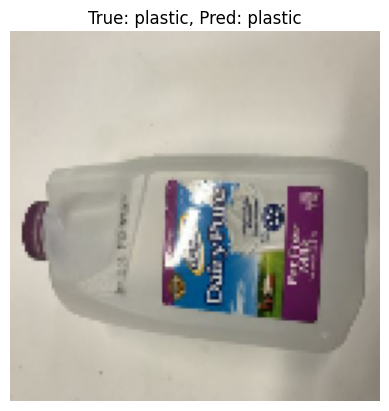

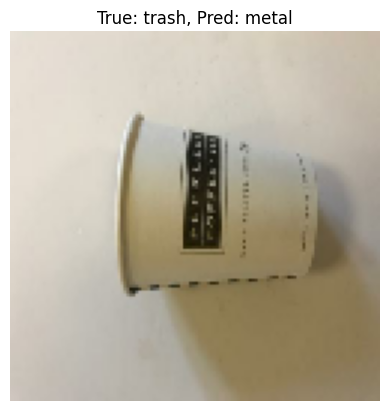

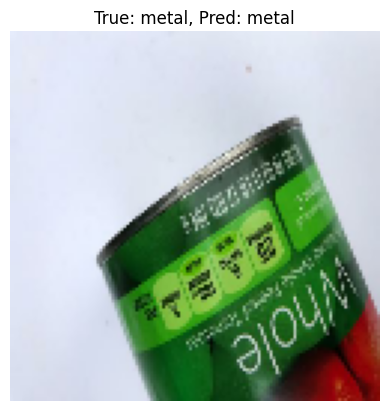

In [28]:
class_names = train_ds.class_names

for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()

In [29]:
model.save('GarbaageClassification.keras')
model = tf.keras.models.load_model('GarbaageClassification.keras')

### Classifying the garbage into different bins after identification

In [30]:
# Category to Bin mapping
bin_mapping = {
    "cardboard": "Blue Bin ",
    "glass": "Green Bin ",
    "metal": "Green Bin ",
    "paper": "Blue Bin ",
    "plastic": "Green Bin",
    "trash": "Red Bin"
}

def get_bin_category(predicted_label):
    print(f"Predicted category: {predicted_label}")
    return bin_mapping.get(predicted_label, "Unknown")

## For user

Saving paper.jpeg to paper.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted category: paper

Predicted Category: paper
Suggested Bin: Blue Bin 


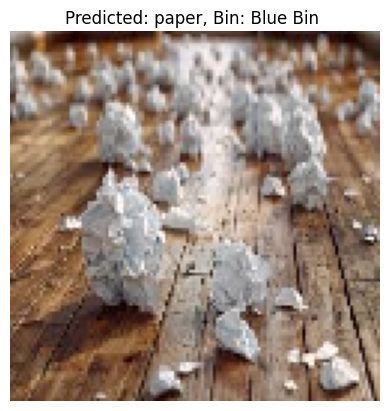

In [31]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # Load the image
    path = fn
    img = image.load_img(path, target_size=image_size)
    img_array = image.img_to_array(img)

    # Expand dimensions to match the model's input shape (batch size of 1)
    img_array = tf.expand_dims(img_array, 0)

    # Preprocess the image (if your model requires specific preprocessing, e.g., scaling)
    # In this case, the ResNet50 model expects images with values scaled to the range of the dataset it was trained on (0-255).
    # If your model was trained with different scaling, adjust this line.
    # For this model, the image is already in the correct range after loading and converting to array.
    # If you were using a different model or had different preprocessing during training,
    # you might need to add a preprocessing step here, like:
    # img_array = preprocess_input(img_array) # if using ResNet50's built-in preprocessing

    # Make a prediction
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Get the bin category
    bin_category = get_bin_category(predicted_class_name)

    # Print the results
    print(f"\nPredicted Category: {predicted_class_name}")
    print(f"Suggested Bin: {bin_category}")

    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}, Bin: {bin_category}")
    plt.axis("off")
    plt.show()

## Gradio Deployment

In [32]:
import gradio as gr

def classify_uploaded_image(img):
    # preprocess the uploaded image
    img_resized = tf.image.resize(img, image_size)
    img_array = tf.expand_dims(img_resized, 0)

    predictions = model.predict(img_array)
    predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
    predicted_class_name = class_names[predicted_class_index]
    bin_category = get_bin_category(predicted_class_name)
    confidence = predictions[0][predicted_class_index]

    result = f"""
    ## 🗑️ Garbage Scan

    - **Predicted Type:** {predicted_class_name.title()}
    - **Suggested Bin:** {bin_category}
    - **Confidence:** {confidence*100:.2f}%
    """
    return result

iface = gr.Interface(
    fn=classify_uploaded_image,
    inputs=gr.Image(type="numpy", label="📤 Upload Trash Image"),
    outputs=gr.Markdown(),
    title="♻️ Garbage Scan",
    description=(
        "Upload a waste image to predict the garbage type and get its suggested disposal bin.\n\n"
        "**Bin color codes:**\n"
        "- Blue Bin 🟦: cardboard, paper\n"
        "- Green Bin 🟩: glass, metal, plastic\n"
        "- Red Bin 🟥: trash"
    ),
    theme="soft",
    allow_flagging="never"
)

iface.launch()


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f3455abf8c75519636.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
